In [1]:
from sqlalchemy import create_engine
from sqlalchemy import (
    Column,
    ForeignKey,
    Integer,
    String,
)
from sqlalchemy.orm import relationship
from sqlalchemy.orm import sessionmaker
import sqlalchemy as db
from sqlalchemy.ext.declarative import declarative_base

USERNAME = "user"
PASSWORD = "pass"
SERVER = "localhost"

# DEFINE THE ENGINE (CONNECTION OBJECT)
engine = create_engine(
    f"mysql+pymysql://{USERNAME}:{PASSWORD}@{SERVER}:3306/networksales", echo=True)

Base = declarative_base()

In [2]:
class Products(Base):
    __tablename__ = "Products"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    Product = Column(String(20), nullable=False)
    Speed = Column(Integer, nullable=False)
    Traffic = Column(Integer, nullable=False)
    Service = Column(String(20), nullable=False)
    Duration_month = Column(Integer, nullable=False)

    # Define a foreign key relationship to the 'Sales' table

    Sales = relationship('Sales', back_populates='Product')

    def __repr__(self):
        return f"<Products(id={self.id})>"

In [3]:
class Customers(Base):
    __tablename__ = "Customers"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    Customer = Column(String(20), nullable=False)

    # Define a foreign key relationship to the 'Sales' table

    Sales = relationship('Sales', back_populates='Customer')

    def __repr__(self):
        return f"<Customers(id={self.id})>"

In [4]:
class Time(Base):
    __tablename__ = "Time"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    Date = Column(String(20), nullable=False)

    # Define a foreign key relationship to the 'Sales' table

    Sales = relationship('Sales', back_populates='Time')

    def __repr__(self):
        return f"<Time(id={self.id}, Date={self.Date})>"

In [5]:
class Province(Base):
    __tablename__ = "Province"

    id = Column(Integer, primary_key=True, nullable=False)
    Province = Column(String(20), nullable=False)

    # Define a one-to-many relationship with 'City' table

    Sales = relationship('Sales', secondary="City", back_populates='Province')

    def __repr__(self):
        return f"<Province(id={self.id}, Province='{self.Province}')>"

In [6]:
class City(Base):
    __tablename__ = "City"

    id = Column(Integer, primary_key=True, autoincrement=True)
    City = Column(String(20), nullable=False)
    Province_id = Column(Integer, ForeignKey("Province.id"), nullable=False)

    Sales = relationship('Sales', secondary="Province", back_populates='City')

    def __repr__(self):
        return f"<City(id={self.id}, Province_id={self.Province_id})>"

In [7]:
class Sales(Base):
    __tablename__ = "Sales"

    id = Column(Integer, primary_key=True, unique=True, autoincrement=True)
    Products_id = Column(Integer, ForeignKey('Products.id'), nullable=False)
    Customers_id = Column(Integer, ForeignKey('Customers.id'), nullable=False)
    Time_id = Column(Integer, ForeignKey('Time.id'), nullable=False)
    Province_id = Column(Integer, ForeignKey('Province.id'), nullable=False)
    City_id = Column(Integer, ForeignKey('City.id'), nullable=False)

    Product = relationship('Products', back_populates='Sales')
    Customer = relationship('Customers', back_populates='Sales')
    Time = relationship('Time', back_populates='Sales')
    Province = relationship('Province', back_populates='Sales')
    City = relationship('City', back_populates='Sales')

    def __repr__(self):
        return f"<Sales(id={self.id}, Products_id={self.Products_id}, Customers_id={self.Customers_id}, Time_id={self.Time_id}, Province_id={self.Province_id}, City_id={self.City_id})>"

In [8]:
from sqlalchemy import text

conn = engine.connect()

# Define the SQL query
sql_query = text(
    """
    SELECT Service, Speed, COUNT(*) as TotalSales
    FROM Sales
    JOIN Products ON Sales.Product_id = Products.id
    GROUP BY Service, Speed
"""
)

# Execute the SQL query
result = conn.execute(sql_query)

# Fetch the results
selected_rows = result.fetchall()

# Close the database connection when you're done
conn.close()

import pandas as pd

df = pd.read_sql_query(sql_query, engine)

2023-09-26 02:33:42,347 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2023-09-26 02:33:42,349 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-09-26 02:33:42,354 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2023-09-26 02:33:42,355 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-09-26 02:33:42,359 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2023-09-26 02:33:42,361 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-09-26 02:33:42,369 INFO sqlalchemy.engine.Engine 
    SELECT Service, Speed, COUNT(*) as TotalSales
    FROM Sales
    JOIN Products ON Sales.Product_id = Products.id
    GROUP BY Service, Speed

2023-09-26 02:33:42,371 INFO sqlalchemy.engine.Engine [generated in 0.00187s] {}
2023-09-26 02:33:44,977 INFO sqlalchemy.engine.Engine 
    SELECT Service, Speed, COUNT(*) as TotalSales
    FROM Sales
    JOIN Products ON Sales.Product_id = Products.id
    GROUP BY Service, Speed

2023-09-26 02:33:44,979 INFO sqlalchemy.engine.Engine [cached since 2.61s ago] {}


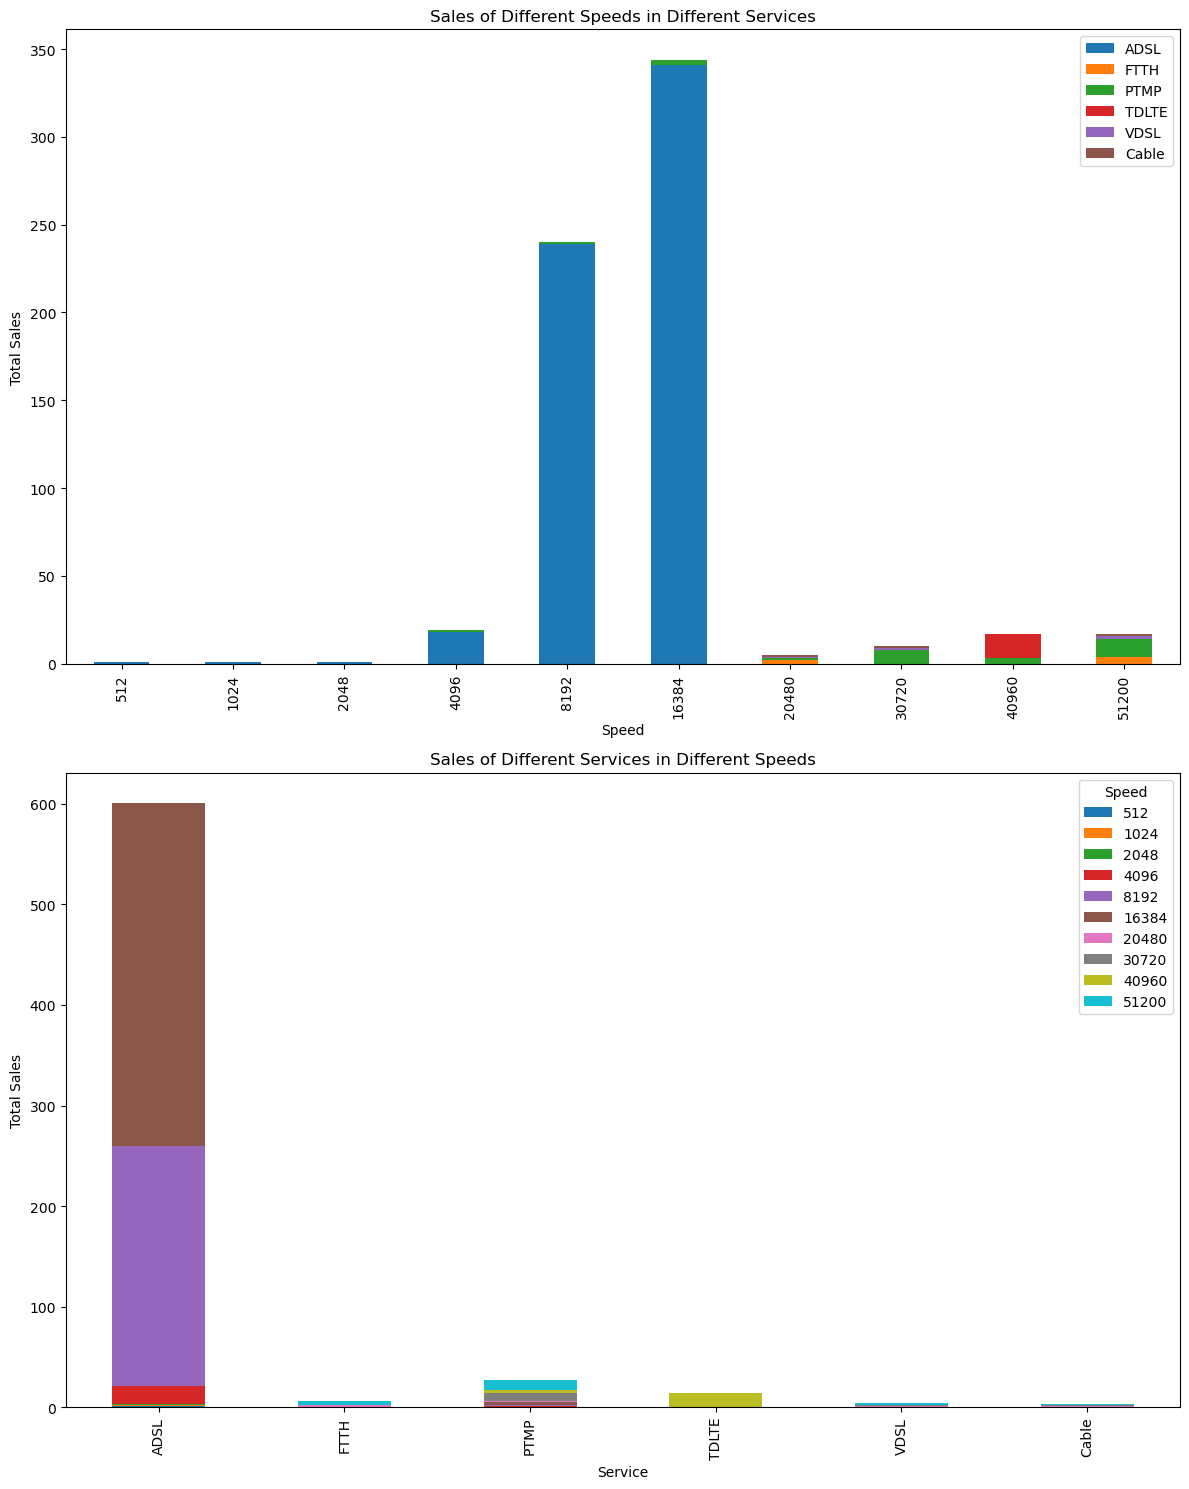

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from the query results
#df = pd.DataFrame(selected_rows, columns=['Service', 'Speed', 'TotalSales'])

# Pivot the data to get a column for each service
pivot_df1 = df.pivot(index='Speed', columns='Service', values='TotalSales')

# Pivot the data to get a column for each service (reversed)
pivot_df2 = df.pivot(index='Service', columns='Speed', values='TotalSales')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

# Plot the first subplot
pivot_df1.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Sales of Different Speeds in Different Services')
axes[0].set_xlabel('Speed')
axes[0].set_ylabel('Total Sales')

# Modify the legend in the first plot
legend_labels = pivot_df1.columns.tolist()
legend_labels[-1] = 'Cable'
axes[0].legend(labels=legend_labels)

# Plot the second subplot
pivot_df2.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Sales of Different Services in Different Speeds')
axes[1].set_xlabel('Service')
axes[1].set_ylabel('Total Sales')

# Modify the labels in the second plot
x_labels = pivot_df2.index.tolist()
x_labels[-1] = 'Cable'
axes[1].set_xticklabels(x_labels)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()